In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import sys
sys.path.append('..')

1.12.0


In [2]:
from configs.wavenet_biogas import hparams
hparams = hparams()
print(hparams)

[('batch_size', 800), ('datagen', 'biogas'), ('dilation_channels', 16), ('dilations', [1, 2, 4, 8, 16, 32, 64]), ('filter_width', 2), ('in_seq_len', 258), ('initial_filter_width', 2), ('input_channels', 1), ('input_dim', 1), ('lambd', 1e-10), ('learning_rate', 0.01), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.995), ('norm_epsilon', 1e-12), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('quantization_channels', 100), ('residual_channels', 16), ('sample_rate', 24), ('scalar_input', False), ('skip_channels', 32), ('test_split', 0.1), ('train_split', 0.8), ('use_biases', True), ('val_split', 0.1)]


In [3]:
hparams.in_seq_len = 24
hparams.out_seq_len = 3 * 128 + 2
hparams.batch_size = 100
hparams.dilations = [1, 2, 4, 8, 16, 32, 64, 128]
hparams.learning_rate = 1e-2
hparams.quantization_channels = 256
hparams.residual_channels = 32
hparams.dilation_channels = 128
hparams.skip_channels = 128
hparams.lambd = 1e-4

In [4]:
from data_loader.sin import *
dataset, dataset_val, dataset_test = load_data(hparams, mode='random_frequency', normalise='random_scale_and_offset')
target, inp, mask, x_max = next(iter(dataset))

Added x, y data
Added y_mask data
Added x_max data


In [5]:
def jitter(inp, target):
    delta = tf.random.uniform((inp.shape[0],1,1), -0.05, 0.05)
    inp = inp + delta
    target = target + delta

    for _ in range(3):
        delta = tf.reduce_min(tf.minimum(tf.concat([inp, target], 1),0), axis=1, keepdims=True)
        inp = inp - 2 * delta
        target = target - 2 * delta

        delta = tf.reduce_max(tf.maximum(tf.concat([inp, target], 1) - 1,0), axis=1, keepdims=True)
        inp = inp - 2 * delta
        target = target - 2 * delta
        
    return inp, target

def create_gaussian_labels(inp):
    labels = tf.cast(hparams.quantization_channels * (inp), tf.int32)
    labels = tf.one_hot(labels, (hparams.quantization_channels+1))
    labels = tf.transpose(labels, [0,1,3,2])
    labels = gaussian_filter(labels)
    labels = tf.squeeze(labels)
    return labels

In [6]:
class WaveNet(tf.keras.Model):
    '''
    https://github.com/NVIDIA/nv-wavenet/blob/master/pytorch/wavenet.py
    '''
    def __init__(self, params):
        super(WaveNet, self).__init__()

        self.num_layers = len(params.dilations)
        self.max_dilation = max(params.dilations)
        self.residual_channels = params.residual_channels 
        self.skip_channels = params.skip_channels
        self.quantization_channels = params.quantization_channels
        self.receptive_field = params.initial_filter_width - 1 + \
                               (params.filter_width - 1) * sum(params.dilations)
        
        self.dilate_layers = []
        self.res_layers = []
        self.skip_layers = []
        
        self.embed = tf.keras.layers.Embedding(self.quantization_channels + 1, self.residual_channels,
                                               name='embedding')
        self.condition = tf.keras.layers.Conv1D(2 * self.residual_channels * self.num_layers, 1,
                                               use_bias=params.use_biases, activation='tanh', name='conditioning')
        self.conv_out = tf.keras.layers.Conv1D(int(self.quantization_channels ** 0.5), 1, use_bias=False,
                                               activation='relu', name='conv_out')
        self.conv_end = tf.keras.layers.Conv1D(self.quantization_channels + 1, 1, use_bias=False,
                                               name='conv_end')
            # Need an extra channel to create enough buckets e.g. [0-100] Needs 101 channels

        loop_factor = np.floor(np.log2(self.max_dilation)) + 1
        for ix in range(self.num_layers):
            dilation = int(2 ** (ix % loop_factor))
            
            layer = 'layer{}'.format(ix)
            in_layer = tf.keras.layers.Conv1D(2 * params.residual_channels, kernel_size=2, padding='causal',
                                          dilation_rate=dilation, use_bias=params.use_biases,
                                          name=layer+'_dilated_conv')
            self.dilate_layers.append(in_layer)

            # last one is not necessary
            if ix < self.num_layers - 1:
                res_layer = tf.keras.layers.Conv1D(params.residual_channels, 1, use_bias=params.use_biases,
                                                name=layer+'_residual_conv')
                self.res_layers.append(res_layer)

            skip_layer = tf.keras.layers.Conv1D(params.skip_channels, 1, use_bias=params.use_biases,
                                                name=layer+'_skip_conv')
            self.skip_layers.append(skip_layer)

    def call(self, inp, mask=None):
        
        assert(np.max(inp) <= 1.)
        assert(np.min(inp) >= 0.)
        inp = tf.cast(self.quantization_channels * tf.squeeze(inp), tf.int16)
        inp = self.embed(inp)
        if mask != None:
            cond = self.condition(mask)
       
        for i in range(self.num_layers):
            in_act = self.dilate_layers[i](inp)
            if mask != None:
                in_act = in_act + cond[:, :, i * 2 * self.residual_channels:(i+1) * 2 * self.residual_channels]
            t_act = tf.tanh(in_act[:, :, :self.residual_channels])
            s_act = tf.sigmoid(in_act[:, :, self.residual_channels:])
            acts = t_act * s_act
            if i < len(self.res_layers):
                res_acts = self.res_layers[i](acts)
            inp = res_acts + inp

            if i == 0:
                output = self.skip_layers[i](acts)
            else:
                output = self.skip_layers[i](acts) + output

        output = tf.nn.relu(output)
        output = self.conv_out(output)
        output = tf.nn.relu(output)
        output = self.conv_end(output)
        
        # Remove last probability and replace first value with 0's because we don't know

        last = output[:, -1:]
        output = output[:, :-1]
        first = last * 0.0
        output = tf.concat((first, output), 1)

        return output

In [ ]:
class WaveNet(tf.keras.Model):
    '''
    https://github.com/NVIDIA/nv-wavenet/blob/master/pytorch/wavenet.py
    Use Skip-Cut Method to accelerate output stack
    Run 1D Conv over inputs
    '''
    def __init__(self, params):
        super(WaveNet, self).__init__()

        self.num_layers = len(params.dilations)
        self.max_dilation = max(params.dilations)
        self.residual_channels = params.residual_channels 
        self.skip_channels = params.skip_channels 
        self.quantization_channels = params.quantization_channels
        
        self.receptive_field = params.initial_filter_width + \
                               (params.filter_width - 1) * sum(params.dilations)
        
        self.dilate_layers = []
        self.res_layers = []
        self.skip_layers = []
        
        self.embed = tf.keras.layers.Embedding(self.quantization_channels, self.residual_channels)
        self.conv_in = tf.keras.layers.Conv1D(self.residual_channels, params.initial_filter_width,
                                              use_bias=False, activation='relu')
        self.conv_out = tf.keras.layers.Conv1D(self.quantization_channels , 1, use_bias=False, activation='relu')
        self.conv_end = tf.keras.layers.Conv1D(self.quantization_channels, 1, use_bias=False)

        loop_factor = np.floor(np.log2(self.max_dilation)) + 1
        for i in range(self.num_layers):
            dilation = int(2 ** (i % loop_factor))
            
            # Kernel size is 2 in nv-wavenet
            in_layer = tf.keras.layers.Conv1D(2 * params.residual_channels, kernel_size=2, padding='causal',
                                              dilation_rate=dilation, use_bias=params.use_biases)
            self.dilate_layers.append(in_layer)

            # last one is not necessary
            if i < self.num_layers - 1:
                res_layer = tf.keras.layers.Conv1D(params.residual_channels, 1, use_bias=params.use_biases)
                self.res_layers.append(res_layer)

            skip_layer = tf.keras.layers.Conv1D(params.skip_channels, 1, use_bias=params.use_biases)

            self.skip_layers.append(skip_layer)

    def call(self, inp, mask):
        output_width = int(inp.shape[1] - self.receptive_field + 1)

        assert(np.max(inp) <= 1.)
        assert(np.min(inp) >= 0.)

        inp = self.embed(tf.cast(self.quantization_channels * (tf.squeeze(inp)), tf.int16))

        inp = self.conv_in(inp)
       
        for i in range(self.num_layers):
            in_act = self.dilate_layers[i](inp)
            t_act = tf.tanh(in_act[:, :, :self.residual_channels])
            s_act = tf.sigmoid(in_act[:, :, self.residual_channels:])
            acts = t_act * s_act
            if i < len(self.res_layers):
                res_acts = self.res_layers[i](acts)
            inp = res_acts + inp

            if i == 0:
                output = self.skip_layers[i](acts)[:,-output_width:]
            else:
                output = self.skip_layers[i](acts)[:,-output_width:] + output

        output = tf.nn.relu(output)
        output = self.conv_out(output)
        output = tf.nn.relu(output)
        output = self.conv_end(output)
        
        # Remove last probability and replace first value with 0's because we don't know

        last = output[:, :, -1:]
        output = output[:, :, :-1]
        first = last * 0.0
        output = tf.concat((first, output), 2)

        return output

In [8]:
model = WaveNet(hparams)
#optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)
optimizer = tf.train.RMSPropOptimizer(hparams.learning_rate)
if True:
    gaussian_filter = tf.keras.layers.Conv2D(1, kernel_size=(1,5), padding='same', use_bias=False,
                        kernel_initializer = tf.initializers.constant([[.01, .05, .88, .05, .01]]))
elif True:
    gaussian_filter = tf.keras.layers.Conv2D(1, kernel_size=(1,3), padding='same', use_bias=False,
                            kernel_initializer = tf.initializers.constant([[.01, .98, .01]]))

In [11]:
# Gaussian dilation embedded label
ix = model.receptive_field + 1

for epoch in range(1000):
    if epoch % 10 == 0:
        dataset, _, _ = load_data(hparams, mode='random_frequency', normalise='random_scale_and_offset')

    losses = []
    for target, inp, mask, x_max in iter(dataset):
        inp = inp[:10]
        mask = mask[:10]
        #if epoch % 3 != 0:
        #   inp, target = jitter(inp, target)
        with tf.GradientTape() as tape:
            pred = model(inp[:,:-1], mask[:,:-1])

            if epoch % 1 != 0:
                # Apply Gaussian dilated loss
                labels = create_gaussian_labels(inp[:,1:])
                ce_loss = tf.losses.softmax_cross_entropy(labels, pred)
            else:
                # Apply one-hot loss
                ce_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                    labels=tf.cast(hparams.quantization_channels * (inp[:,1:]), tf.int32)[:,:,0],
                    logits=pred)
                ce_loss = tf.reduce_mean(ce_loss)
            l2_loss = tf.reduce_sum([tf.reduce_sum(var ** 2) * (1 if var.name.find('bias') == -1 else 0)\
                                     for var in model.trainable_variables]) * hparams.lambd
            loss = tf.reduce_sum([ce_loss, l2_loss])
            
        # Update gradients
        variables = model.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        losses.append(loss)
    
    optimizer._learning_rate *= 0.999
    if epoch % 1 == 0:
        print(epoch, ': ', np.round(np.dstack(losses).mean(), 3), np.round(ce_loss, 3), np.round(l2_loss,3))

Added x, y data
Added y_mask data
Added x_max data
0 :  5.653 5.549 0.103
1 :  5.653 5.549 0.103
2 :  5.653 5.549 0.103
3 :  5.653 5.549 0.103
4 :  5.653 5.549 0.103
5 :  5.653 5.549 0.103
6 :  5.653 5.549 0.103
7 :  5.653 5.549 0.103
8 :  5.653 5.549 0.103
9 :  5.653 5.549 0.103
Added x, y data
Added y_mask data
Added x_max data
10 :  5.652 5.548 0.103
11 :  5.652 5.548 0.103
12 :  5.652 5.548 0.103
13 :  5.651 5.548 0.103
14 :  5.651 5.548 0.103
15 :  5.651 5.548 0.103
16 :  5.651 5.548 0.103
17 :  5.651 5.548 0.103
18 :  5.651 5.548 0.103
19 :  5.651 5.548 0.103
Added x, y data
Added y_mask data
Added x_max data
20 :  5.652 5.549 0.103
21 :  5.652 5.549 0.103
22 :  5.652 5.549 0.103
23 :  5.652 5.549 0.103
24 :  5.652 5.549 0.103
25 :  5.652 5.549 0.103
26 :  5.652 5.549 0.103
27 :  5.652 5.548 0.103
28 :  5.652 5.548 0.103
29 :  5.652 5.548 0.103
Added x, y data
Added y_mask data
Added x_max data
30 :  5.653 5.55 0.103
31 :  5.653 5.55 0.103
32 :  5.653 5.55 0.103
33 :  5.653 5.55 

279 :  3.402 3.273 0.129
Added x, y data
Added y_mask data
Added x_max data
280 :  4.982 4.852 0.13
281 :  4.455 4.326 0.129
282 :  4.047 3.918 0.129
283 :  3.786 3.657 0.13
284 :  3.707 3.577 0.13
285 :  3.431 3.3 0.131
286 :  3.297 3.166 0.131
287 :  3.221 3.089 0.132
288 :  3.178 3.045 0.133
289 :  3.154 3.02 0.134
Added x, y data
Added y_mask data
Added x_max data
290 :  5.403 5.268 0.135
291 :  4.133 4.0 0.133
292 :  3.839 3.706 0.133
293 :  3.808 3.675 0.133
294 :  3.765 3.631 0.134
295 :  3.695 3.561 0.135
296 :  3.526 3.39 0.136
297 :  3.36 3.224 0.136
298 :  3.28 3.143 0.137
299 :  3.211 3.073 0.138
Added x, y data
Added y_mask data
Added x_max data
300 :  5.48 5.342 0.139
301 :  4.738 4.6 0.138
302 :  4.142 4.005 0.137
303 :  3.714 3.577 0.137
304 :  3.485 3.347 0.138
305 :  3.316 3.177 0.138
306 :  3.132 2.993 0.139
307 :  2.995 2.856 0.14
308 :  2.96 2.82 0.14
309 :  3.058 2.917 0.141
Added x, y data
Added y_mask data
Added x_max data
310 :  5.612 5.47 0.142
311 :  4.419 4.

554 :  3.096 2.9 0.197
555 :  2.928 2.732 0.197
556 :  2.838 2.641 0.197
557 :  2.78 2.583 0.197
558 :  2.748 2.551 0.198
559 :  2.743 2.545 0.198
Added x, y data
Added y_mask data
Added x_max data
560 :  5.502 5.303 0.198
561 :  4.274 4.077 0.197
562 :  3.693 3.496 0.197
563 :  3.386 3.189 0.197
564 :  3.224 3.026 0.198
565 :  3.114 2.916 0.198
566 :  3.085 2.887 0.199
567 :  3.072 2.873 0.199
568 :  2.96 2.76 0.2
569 :  2.848 2.648 0.2
Added x, y data
Added y_mask data
Added x_max data
570 :  5.301 5.1 0.201
571 :  4.436 4.236 0.2
572 :  3.701 3.502 0.199
573 :  3.409 3.21 0.199
574 :  3.327 3.128 0.199
575 :  3.312 3.112 0.2
576 :  3.36 3.16 0.2
577 :  3.23 3.03 0.2
578 :  2.972 2.771 0.201
579 :  2.833 2.631 0.201
Added x, y data
Added y_mask data
Added x_max data
580 :  4.878 4.676 0.202
581 :  4.159 3.958 0.201
582 :  4.015 3.815 0.2
583 :  3.537 3.337 0.2
584 :  3.137 2.936 0.2
585 :  2.912 2.711 0.201
586 :  2.785 2.584 0.201
587 :  2.706 2.504 0.201
588 :  2.646 2.444 0.202
58

830 :  4.392 4.165 0.227
831 :  3.889 3.663 0.226
832 :  3.915 3.689 0.226
833 :  3.736 3.51 0.226
834 :  3.136 2.91 0.226
835 :  2.856 2.63 0.226
836 :  2.766 2.54 0.226
837 :  2.705 2.479 0.226
838 :  2.654 2.428 0.227
839 :  2.612 2.385 0.227
Added x, y data
Added y_mask data
Added x_max data
840 :  4.905 4.678 0.227
841 :  3.698 3.472 0.226
842 :  3.264 3.038 0.226
843 :  3.034 2.808 0.226
844 :  2.921 2.695 0.226
845 :  2.863 2.636 0.227
846 :  2.835 2.608 0.227
847 :  2.852 2.625 0.227
848 :  2.926 2.698 0.227
849 :  2.972 2.745 0.228
Added x, y data
Added y_mask data
Added x_max data
850 :  5.012 4.784 0.228
851 :  3.611 3.384 0.227
852 :  3.195 2.968 0.227
853 :  3.046 2.819 0.227
854 :  2.944 2.716 0.228
855 :  2.747 2.519 0.228
856 :  2.648 2.419 0.228
857 :  2.561 2.332 0.229
858 :  2.493 2.264 0.229
859 :  2.455 2.226 0.23
Added x, y data
Added y_mask data
Added x_max data
860 :  4.513 4.282 0.23
861 :  3.935 3.705 0.23
862 :  3.394 3.164 0.229
863 :  3.474 3.245 0.229
864 

In [ ]:
# One-shot train dataset
# Designed for use with the whole dataset at once
for epoch in range(100):
    losses = []
    inp, target, mask, x_max = next(iter(dataset))
    with tf.GradientTape() as tape:
        pred = model_(inp[:,:-2], mask)

        if epoch % 2 == 0:
            pred = model_(inp[:,:-2], mask)
            pred = tf.log(tf.nn.softmax(pred))
            pred0 = tf.random.multinomial(pred[0], 1)
            pred1 = tf.random.multinomial(pred[1], 1)
            pred = tf.stack([pred0, pred1]) / 500 + 0.85
            pred = model_(pred, mask)

        labels = create_gaussian_labels(inp[:,2:])
        loss = tf.losses.softmax_cross_entropy(labels, pred)

    # Update gradients
    variables = model_.variables
    gradients = tape.gradient(loss, variables)
    optimizer_.apply_gradients(zip(gradients, variables))
    losses.append(loss)
    
    if epoch % 10 == 0:
        print(epoch, ': ', np.dstack(losses).mean())

In [ ]:
# One-Hot embedded label
for epoch in range(2):
    losses = []
    for inp, target, mask, x_max in iter(dataset):
        inp, target = jitter(inp, target)
        with tf.GradientTape() as tape:
            pred = model_(inp, mask)
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                    labels=tf.cast(500 * (inp[:,127:] - 0.85), tf.int32)[:,:,0],
                    logits=pred)
            
        # Update gradients
        variables = model_.variables
        gradients = tape.gradient(loss, variables)
        optimizer_.apply_gradients(zip(gradients, variables))
        losses.append(loss)

    print(epoch, ': ', np.dstack(losses).mean())

In [103]:
target, inp, mask, x_max = next(iter(dataset))

forecast = inp[:8,-214:]
for n in range(72):
    pred = model_(forecast[:,-214:], mask[:8,-214:])
    pred = tf.log(tf.nn.softmax(pred[:,-1]))
    pred = tf.random.multinomial(pred, 1) / hparams.quantization_channels
    #pred = tf.argmax(pred, -1) / (hparams.quantization_channels + 1)
    pred = tf.reshape(tf.cast(pred, tf.float32), [-1,1,1])
    forecast = tf.concat([forecast, pred], 1)
    

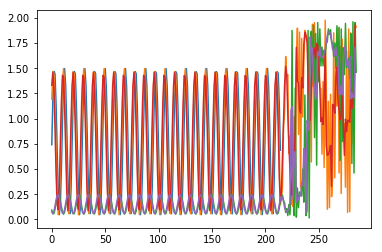

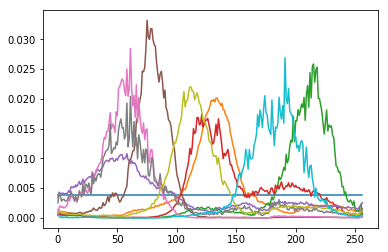

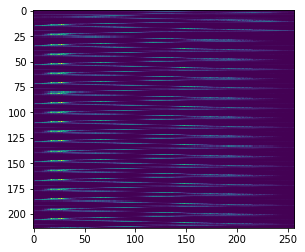

In [106]:
plt.plot(np.squeeze(inp[2,:350]) * np.max(x_max))
#plt.plot(np.squeeze(np.concatenate([inp[0], inp[129]], axis=0)) * np.max(x_max))

plt.plot(np.squeeze(forecast[2:4]).T * np.max(x_max))
plt.plot(np.convolve(forecast[2,:,0], [0.5, 0.5])[1:-1] * np.max(x_max))
plt.plot(np.convolve(forecast[3,:,0], [0.5, 0.5])[1:-1] * np.max(x_max))


plt.show()

pred = model_(inp[:,-214:], mask[:,-214:])
plt.plot(np.squeeze(tf.nn.softmax(pred[2,:10])).T)
plt.show()
plt.imshow(np.squeeze(tf.nn.softmax(pred))[2])
plt.show()

## Continuous Model

loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

In [ ]:
class WaveNet(tf.keras.Model):
    '''
    https://github.com/NVIDIA/nv-wavenet/blob/master/pytorch/wavenet.py
    Teacher forcing model
    '''
    def __init__(self, params):
        super(WaveNet, self).__init__()

        self.num_layers = len(params['dilations'])
        self.max_dilation = max(params['dilations'])
        self.residual_channels = params['residual_channels'] 
        self.skip_channels = params['skip_channels'] 
        self.out_channels = params['quantization_channels']
        
        self.receptive_field = params['initial_filter_width'] - 1 + \
                               (params['filter_width'] - 1) * sum(params['dilations'])
        
        self.dilate_layers = []
        self.res_layers = []
        self.skip_layers = []
        
        #self.embed = tf.keras.layers.Embedding(self.out_channels, self.residual_channels)
        self.conv_out = tf.keras.layers.Conv1D(params['quantization_channels'] , 1, use_bias=False)
        self.conv_end = tf.keras.layers.Conv1D(1, 1, use_bias=False)

        loop_factor = np.floor(np.log2(self.max_dilation)) + 1
        for i in range(self.num_layers):
            dilation = int(2 ** (i % loop_factor))
            
            # Kernel size is 2 in nv-wavenet
            in_layer = tf.keras.layers.Conv1D(2 * params['residual_channels'], kernel_size=2,
                                              dilation_rate=dilation, use_bias=params['use_biases'])
            self.dilate_layers.append(in_layer)

            # last one is not necessary
            if i < self.num_layers - 1:
                res_layer = [tf.keras.layers.Conv1D(params['residual_channels'], 1, use_bias=params['use_biases']),
                             tf.keras.layers.Conv1D(params['residual_channels'], kernel_size=2,
                                              dilation_rate=dilation, use_bias=params['use_biases'])]
                self.res_layers.append(res_layer)

            if i == 0:
                skip_layer = [tf.keras.layers.Conv1D(params['skip_channels'], 1, use_bias=params['use_biases'])]
            else:
                skip_layer = [tf.keras.layers.Conv1D(params['skip_channels'], 1, use_bias=params['use_biases']),
                              tf.keras.layers.Conv1D(params['skip_channels'], kernel_size=2,
                                              dilation_rate=dilation, use_bias=params['use_biases'])]

            self.skip_layers.append(skip_layer)

    def call(self, inp, mask):
       
        for i in range(self.num_layers):
            in_act = self.dilate_layers[i](inp)
            t_act = tf.tanh(in_act[:, :, :self.residual_channels])
            s_act = tf.sigmoid(in_act[:, :, self.residual_channels:])
            acts = t_act * s_act
            if i < len(self.res_layers):
                res_acts = self.res_layers[i][0](acts)
                inp = res_acts + self.res_layers[i][1](inp)

            if i == 0:
                output = self.skip_layers[i][0](acts)
            else:
                output = self.skip_layers[i][0](acts) + self.skip_layers[i][1](output)

        output = tf.nn.relu(output)
        output = self.conv_out(output)
        output = tf.nn.relu(output)
        output = self.conv_end(output)
        
        return output

In [ ]:
model_ = WaveNet(params)
optimizer_= tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

In [ ]:
# Continuous Prediction
for epoch in range(10):
    losses = []
    for inp, target, mask, x_max in iter(dataset):
        inp, target = jitter(inp, target)
        with tf.GradientTape() as tape:
            pred = model_(inp[:,:-1], mask)
            loss = tf.losses.mean_squared_error(inp[:,128:], pred)
            
        # Update gradients
        variables = model_.variables
        gradients = tape.gradient(loss, variables)
        optimizer_.apply_gradients(zip(gradients, variables))
        losses.append(loss)

    print(epoch, ': ', np.dstack(losses).mean())

In [ ]:
forecast = inp[:,:129]
for _ in range(72):
    pred = model_(forecast[:,-128:], mask)
    forecast = tf.concat([forecast, pred], 1)

In [ ]:
plt.plot(np.squeeze(forecast[:2]).T * np.max(x_max))
plt.plot(np.squeeze(inp[0,:200]) * np.max(x_max))
plt.show()

plt.plot(np.squeeze(pred).T * np.max(x_max))

In [ ]:
plt.plot(np.squeeze(inp[0::24, :72]).T)

## Test Hyperparameters

In [ ]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

inp, target, mask, x_max = next(iter(dataset))

#for lr in np.random.uniform(-8, -1, 10):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model_ = WaveNet(params)
    optimizer_ = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        trainer.train_model(model_, optimizer_, dataset, hparams, epochs = 3, verbose=False)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*10000, accuracy * 10000, run_time))
    
    models.append(model_)
    stats.append(stat)

Learning Rate -3.5000 Loss 0.0254 Accuracy 0.0254 Time 32.2
Learning Rate -3.0000 Loss 0.0247 Accuracy 0.0247 Time 31.2
Learning Rate -2.5000 Loss 0.0254 Accuracy 0.0254 Time 31.5

## Test Model Accuracy

In [ ]:
model_accuracy = []

In [ ]:
for name, dataset_eval in([['Train', dataset], ['Test', dataset_test]]):
    print(name + ' Results')
    total_accuracy = []
    x_variance = x_var(hparams, mode=get_fields)

    for i, (inp, target, mask, x_max) in enumerate(dataset_eval):
        forecast = model(inp, mask)

        accuracy = tf.squeeze(forecast - target) * x_max
        accuracy = accuracy ** 2 / x_variance
        accuracy = np.mean(accuracy, axis=0)

        total_accuracy.append(accuracy)

    model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))

    print('Total RSE Accuracy: %.4f' % np.mean(total_accuracy))
    print('Total MSE Accuracy: %.4f' % (np.mean(total_accuracy) * x_variance))
    plt.plot(np.mean(total_accuracy, axis=0))
plt.show()

https://github.com/ibab/tensorflow-wavenet
https://github.com/basveeling/wavenet